In [1]:
import pynbody
import pylab
import matplotlib.pyplot as plt
import numpy as np
from pynbody import units
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from scipy import stats
from scipy import constants
import pynbody.filt as f

In [2]:
pynbody.config['sph']['smooth-particles'] = 50
pynbody.config["number_of_threads"] = 2

In [3]:
s = pynbody.load('../Documents/Bachelorthesis/simulations/g8.26/g8.26e11.01024')
#s2 = pynbody.load('output_279/2.79e12.02000')
h = s.halos()
#h2 = s2.halos()

# main halo
h1 = h[1]
#h2_main = h2[1]

# convert to physical units
s.physical_units()

# face on
pynbody.analysis.angmom.faceon(h1)


In [4]:
(10*1.673*10**(-27)*units.kg/units.cm**3).ratio(units.Msol/units.kpc**3)
disk = f.LowPass('r', '72 kpc') & f.BandPass('z', '-0.5 kpc', '0.5 kpc')
#sf = f.HighPass('rho', '247133368.31459114 Msol kpc^-3') & f.LowPass('temp', '30000 K')
gal = h1[disk]
#gal_sf = gal.g[sf]

In [5]:
@pynbody.snapshot.SimSnap.stable_derived_quantity
def mass_sph(self):
    import logging
    logger = logging.getLogger('pynbody.sph')

    pynbody.sph.build_tree_or_trees(self)

    logger.info('Calculating sph mean')
    
    mass_sph = self.kdtree.sph_mean(self['mass'], nsmooth=pynbody.config['sph']['smooth-particles'])
    

    return mass_sph

@pynbody.snapshot.SimSnap.derived_quantity
def v_curl2(self):
    """Squared velocity"""
    return (self['v_curl'] ** 2).sum(axis=1)

In [6]:
s.g['rho']
s.s['rho']
s.g['v_div']
s.s['v_div']
s.g['v_curl']
s.s['v_curl']
s.g['mass_sph']
s.s['mass_sph']
s.g['v_curl2']
s.s['v_curl2']

SimArray([11374534.71387364,  4377798.95466321,  2607322.92216603, ...,
            943883.48710233,  2241833.05351436,  1097491.8022819 ], 'km**2 kpc**-2 s**-2')

In [7]:
@pynbody.snapshot.SimSnap.stable_derived_quantity
def vel_div(self):
    import logging
    logger = logging.getLogger('pynbody.sph')

    pynbody.sph.build_tree(self)

    logger.info('Calculating velocity divergence')
    
    vel_div = self.kdtree.sph_divergence(self['vel'], nsmooth=pynbody.config['sph']['smooth-particles'])


    return vel_div

In [8]:
@pynbody.snapshot.SimSnap.stable_derived_quantity
def vel_curl(self):
    import logging
    logger = logging.getLogger('pynbody.sph')

    pynbody.sph.build_tree_or_trees(self)

    logger.info('Calculating velocity curl')
    
    vel_curl = self.kdtree.sph_curl(self['vel'], nsmooth=pynbody.config['sph']['smooth-particles'])

    return vel_curl


In [9]:
# mass weighted 2d histograms

def mw_hist(fam, key, b):
    hist, xbin, ybin = np.histogram2d(fam['x'],fam['y'],weights=fam[key]*fam['mass'], bins=b, range=((-50,50),(-50,50)))
    mass, xbin, ybin = np.histogram2d(fam['x'],fam['y'],weights=fam['mass'], bins=b, range=((-50,50),(-50,50)))
    return hist/mass


In [10]:
m_part = gal.g['mass']
m_kern = gal.g['rho']*4/3*np.pi*gal.g['smooth']**3 
m_sph = gal.g['mass_sph']

gal.g['radius'] = gal.g['smooth'].in_units('m') #in units m
gal.g['radius_2'] = gal.g['radius']
gal.g['radius_2'] = (m_sph.in_units('kg')/gal.g['rho']*((3.0857e+19)**3/(2e+30))*3/(4*np.pi))**(1/3)
gal.g['radius_3'] = gal.g['radius']
gal.g['radius_3'] = (m_part.in_units('kg')/gal.g['rho']*((3.0857e+19)**3/(2e+30))*3/(4*np.pi))**(1/3)

gal.g['alpha'] = (5*(gal.g['v_disp'].in_units('m s**-1'))**2*gal.g['radius']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_sph.in_units('kg'))).in_units(1)
gal.g['alpha_2'] = (5*(gal.g['v_disp'].in_units('m s**-1'))**2*gal.g['radius_2']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_sph.in_units('kg'))).in_units(1)
gal.g['alpha_3'] = (5*(gal.g['v_disp'].in_units('m s**-1'))**2*gal.g['radius_3']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_part.in_units('kg'))).in_units(1)
gal.g['alpha_4'] = 1/4*(np.abs(gal.g['v_div'].in_units('s**-1'))**2+np.sqrt(gal.g['v_curl2'].in_units('s**-2'))**2)/(constants.G*units.m**3*units.kg**-1*gal.g['rho'].in_units('kg m**-3')).in_units(1)
#gal.g['alpha_5'] = # mit Ekin und Epot

b = 2.02
gal.g['efficiency'] = np.exp(-b*gal.g['alpha_4']**(1/2))

In [11]:
low_alpha = f.LowPass('alpha', '100')
low_alpha_2 = f.LowPass('alpha_2', '100')
low_alpha_3 = f.LowPass('alpha_3', '100')
low_alpha_4 = f.LowPass('alpha_4', '100')

gal_low_alpha = gal.g[low_alpha]
gal_low_alpha_2 = gal.g[low_alpha_2]
gal_low_alpha_3 = gal.g[low_alpha_3]
gal_low_alpha_4 = gal.g[low_alpha_4]

In [12]:
gal.g['alpha_4']

SimArray([0.61600345, 7.78896643, 3.89254692, ..., 0.64236682, 5.03824322,
          1.39917748], '1.00e+00')

In [13]:
pynbody.config['sph']['Kernel']

'CubicSpline'

In [14]:
s = pynbody.load('../Documents/Bachelorthesis/simulations/g8.26/g8.26e11.01024')
#s2 = pynbody.load('output_279/2.79e12.02000')
h = s.halos()
#h2 = s2.halos()

# main halo
h1 = h[1]
#h2_main = h2[1]

# convert to physical units
s.physical_units()

# face on
pynbody.analysis.angmom.faceon(h1)

In [15]:
pynbody.config['sph']['Kernel'] = 'WendlandC2'

In [16]:
s.g['rho']
s.s['rho']
s.g['v_div']
s.s['v_div']
s.g['v_curl']
s.s['v_curl']
s.g['mass_sph']
s.s['mass_sph']
s.g['v_curl2']
s.s['v_curl2']

SimArray([10156097.07722665,  4152932.11254102,  2276899.30100165, ...,
            933652.4261445 ,  1451125.61343043,   662849.38858285], 'km**2 kpc**-2 s**-2')

In [17]:
m_part_W = gal.g['mass']
m_kern_W = gal.g['rho']*4/3*np.pi*gal.g['smooth']**3 
m_sph_W = gal.g['mass_sph']

gal.g['radius'] = gal.g['smooth'].in_units('m') #in units m
gal.g['radius_2'] = gal.g['radius']
gal.g['radius_2'] = (m_sph.in_units('kg')/gal.g['rho']*((3.0857e+19)**3/(2e+30))*3/(4*np.pi))**(1/3)
gal.g['radius_3'] = gal.g['radius']
gal.g['radius_3'] = (m_part.in_units('kg')/gal.g['rho']*((3.0857e+19)**3/(2e+30))*3/(4*np.pi))**(1/3)

gal.g['alpha_W'] = (5*(gal.g['v_disp'].in_units('m s**-1'))**2*gal.g['radius']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_sph.in_units('kg'))).in_units(1)
gal.g['alpha_2_W'] = (5*(gal.g['v_disp'].in_units('m s**-1'))**2*gal.g['radius_2']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_sph.in_units('kg'))).in_units(1)
gal.g['alpha_3_W'] = (5*(gal.g['v_disp'].in_units('m s**-1'))**2*gal.g['radius_3']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_part.in_units('kg'))).in_units(1)
gal.g['alpha_4_W'] = 1/4*(np.abs(gal.g['v_div'].in_units('s**-1'))**2+np.sqrt(gal.g['v_curl2'].in_units('s**-2'))**2)/(constants.G*units.m**3*units.kg**-1*gal.g['rho'].in_units('kg m**-3')).in_units(1)
#gal.g['alpha_5'] = # mit Ekin und Epot

b = 2.02
gal.g['efficiency_W'] = np.exp(-b*gal.g['alpha_4']**(1/2))

In [18]:
low_alpha_W = f.LowPass('alpha_W', '100')
low_alpha_2_W = f.LowPass('alpha_2_W', '100')
low_alpha_3_W = f.LowPass('alpha_3_W', '100')
low_alpha_4_W = f.LowPass('alpha_4_W', '100')

gal_low_alpha_W = gal.g[low_alpha_W]
gal_low_alpha_2_W = gal.g[low_alpha_2_W]
gal_low_alpha_3_W = gal.g[low_alpha_3_W]
gal_low_alpha_4_W = gal.g[low_alpha_4_W]

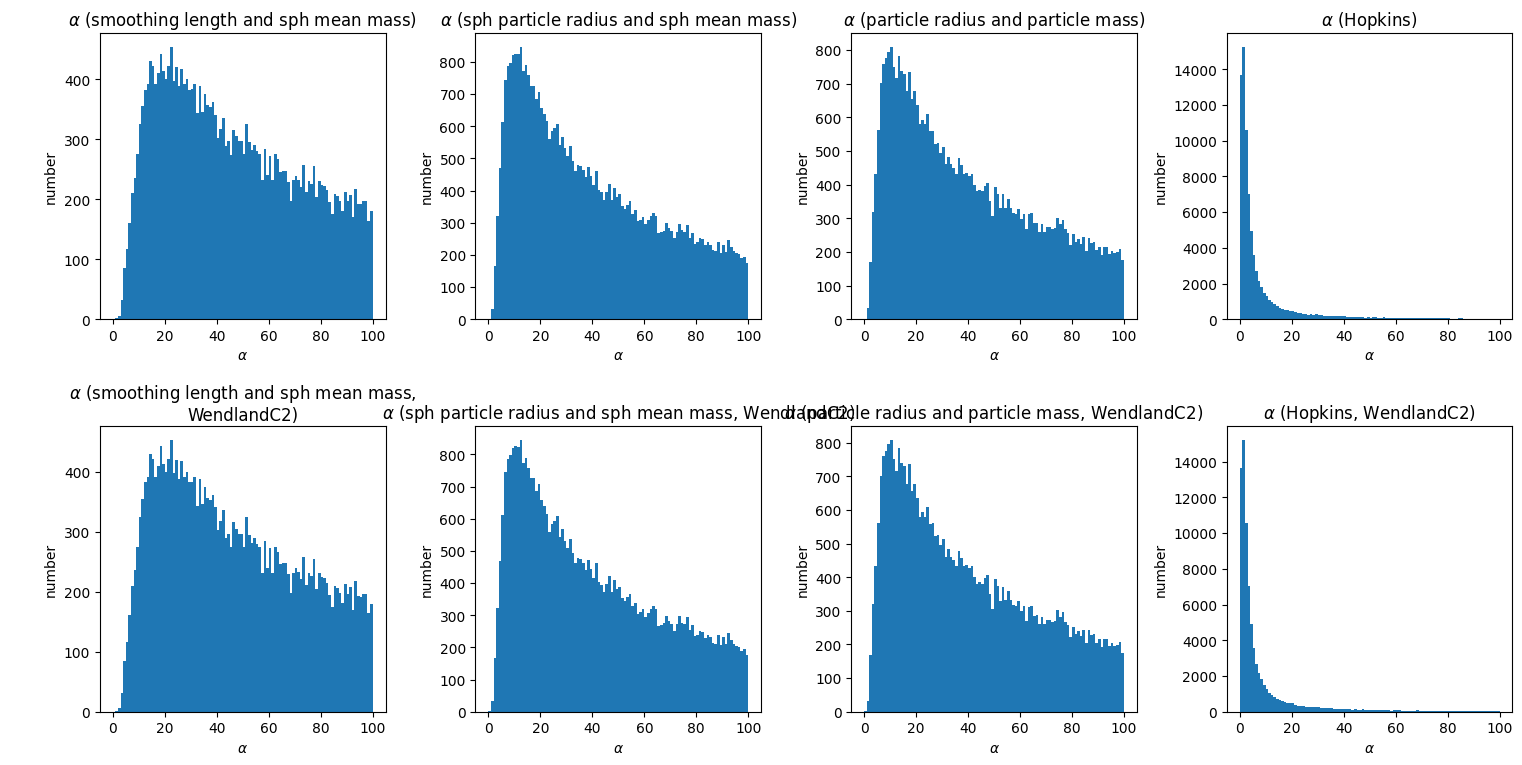

In [19]:
fig = plt.figure(figsize = (15,8))

ax1 = plt.subplot(241)
ax1.hist(gal.g['alpha'], bins = 100, range= (0,100))
ax1.set_title(r'$\alpha$ (smoothing length and sph mean mass)')
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel('number')
ax1.set_aspect(1./ax1.get_data_ratio())


ax2 = plt.subplot(242)
ax2.hist(gal.g['alpha_2'], bins = 100,  range= (0,100))
ax2.set_title(r'$\alpha$ (sph particle radius and sph mean mass)')
ax2.set_xlabel(r'$\alpha$')
ax2.set_ylabel('number')
ax2.set_aspect(1./ax2.get_data_ratio())


ax3 = plt.subplot(243)
ax3.hist(gal.g['alpha_3'], bins = 100,  range= (0,100))
ax3.set_title(r'$\alpha$ (particle radius and particle mass)')
ax3.set_xlabel(r'$\alpha$')
ax3.set_ylabel('number')
ax3.set_aspect(1./ax3.get_data_ratio())


ax4 = plt.subplot(244)
ax4.hist(gal.g['alpha_4'], bins = 100, range= (0,100))
ax4.set_title(r'$\alpha$ (Hopkins)')
ax4.set_xlabel(r'$\alpha$')
ax4.set_ylabel('number')
ax4.set_aspect(1./ax4.get_data_ratio())

ax5 = plt.subplot(245)
ax5.hist(gal.g['alpha_W'], bins = 100, range= (0,100))
ax5.set_title(r'$\alpha$ (smoothing length and sph mean mass, WendlandC2)', wrap = True)
ax5.set_xlabel(r'$\alpha$')
ax5.set_ylabel('number')
ax5.set_aspect(1./ax5.get_data_ratio())

ax6 = plt.subplot(246)
ax6.hist(gal.g['alpha_2_W'], bins = 100, range= (0,100))
ax6.set_title(r'$\alpha$ (sph particle radius and sph mean mass, WendlandC2)', wrap = True)
ax6.set_xlabel(r'$\alpha$')
ax6.set_ylabel('number')
ax6.set_aspect(1./ax6.get_data_ratio())

ax7 = plt.subplot(247)
ax7.hist(gal.g['alpha_3_W'], bins = 100, range= (0,100))
ax7.set_title(r'$\alpha$ (particle radius and particle mass, WendlandC2)', wrap = True)
ax7.set_xlabel(r'$\alpha$')
ax7.set_ylabel('number')
ax7.set_aspect(1./ax7.get_data_ratio())

ax8 = plt.subplot(248)
ax8.hist(gal.g['alpha_4_W'], bins = 100, range= (0,100))
ax8.set_title(r'$\alpha$ (Hopkins, WendlandC2)')
ax8.set_xlabel(r'$\alpha$')
ax8.set_ylabel('number')
ax8.set_aspect(1./ax8.get_data_ratio())


fig.tight_layout()
plt.show()

In [25]:
gal.g['alpha_4'].min()

SimArray(0.0045744, '1.00e+00')

In [26]:
gal.g['alpha_4_W'].min()

SimArray(0.0045744, '1.00e+00')

In [27]:
pynbody.config['sph']['Kernel']

'WendlandC2'

/tmp/ipykernel_7669/3198553351.py:6: RuntimeWarning: invalid value encountered in divide
  return hist/mass


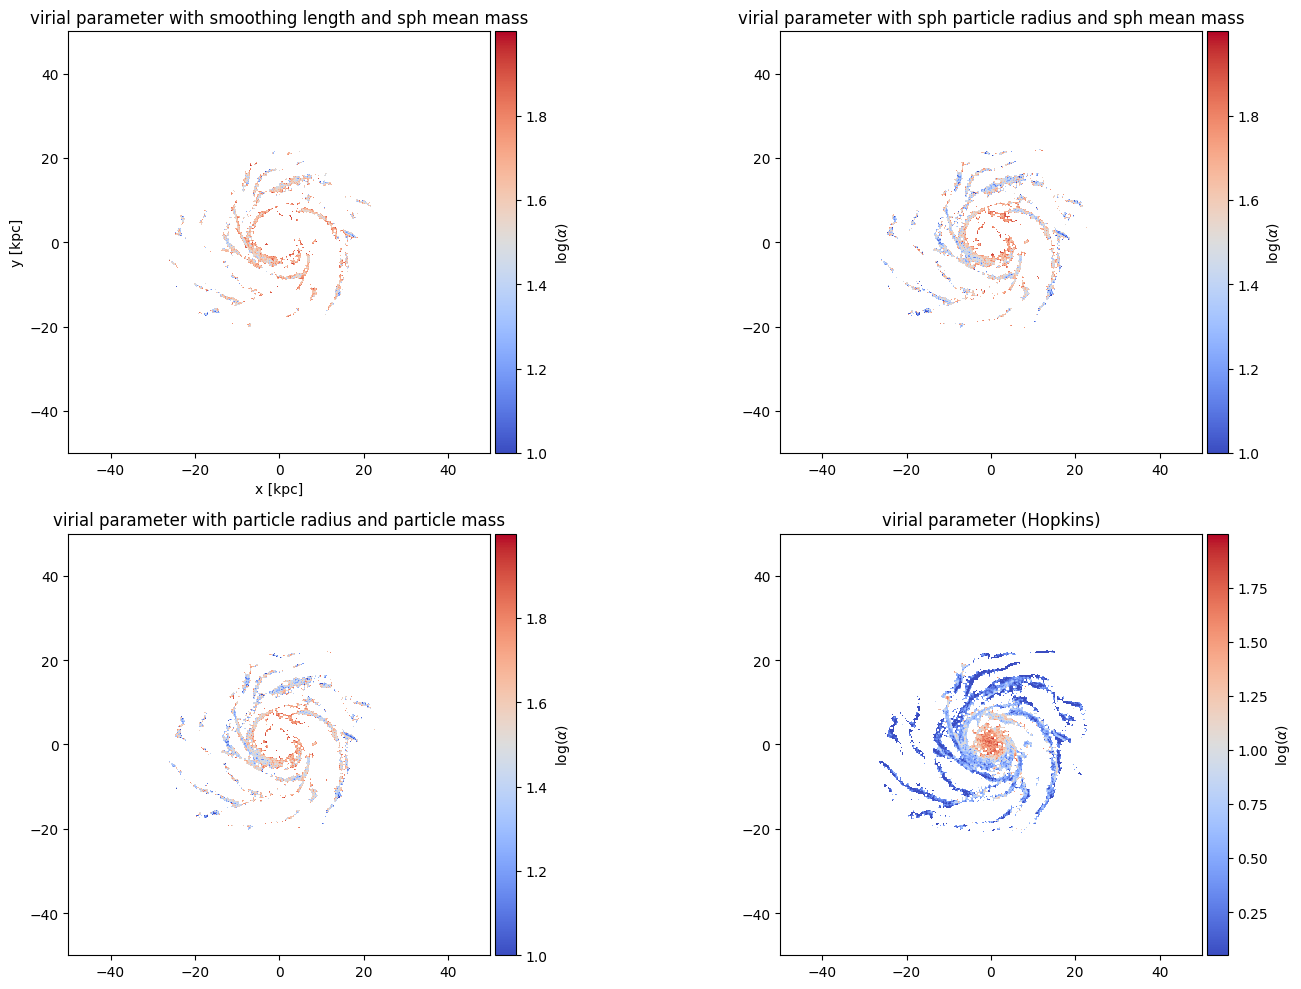

In [42]:
fig = plt.figure(figsize = (15,10))

ax1 = plt.subplot(221)
im1 = ax1.imshow(np.log10(mw_hist(gal_low_alpha, 'alpha', 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = 1.0)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = r'log($\alpha$)')
ax1.set_title('virial parameter with smoothing length and sph mean mass')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')
ax1.set_xlim(-50, 50)
ax1.set_ylim(-50, 50)

ax2 = plt.subplot(222)
im2 = ax2.imshow(np.log10(mw_hist(gal_low_alpha_2, 'alpha_2', 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = 1.0)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label = r'log($\alpha$)')
ax2.set_title('virial parameter with sph particle radius and sph mean mass')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')
#ax2.set_xlim(-20, 20)
#ax2.set_ylim(-20,20)

ax3 = plt.subplot(223)
im3 = ax3.imshow(np.log10(mw_hist(gal_low_alpha_3, 'alpha_3', 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = 1.0)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical', label = r'log($\alpha$)')
ax3.set_title('virial parameter with particle radius and particle mass')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')
#ax3.set_xlim(-20, 20)
#ax3.set_ylim(-20,20)

ax4 = plt.subplot(224)
im4 = ax4.imshow(np.log10(mw_hist(gal_low_alpha_4, 'alpha_4', 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = 0.05)
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical', label = r'log($\alpha$)')
ax4.set_title('virial parameter (Hopkins)')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')
#ax4.set_xlim(-20, 20)
#ax4.set_ylim(-20,20)


fig.tight_layout()
plt.show()

In [ ]:
# densities
#g_hist, g_xbins, g_ybins = np.histogram2d(gal.g['x'],gal.g['y'],weights=gal.g['rho'], bins=500, range=((-50,50),(-50,50)))
#s_hist, s_xbins, s_ybins = np.histogram2d(gal.s['x'],gal.s['y'],weights=gal.s['rho'], bins=500, range=((-50,50),(-50,50)))
g_hist, g_xedge, g_yedge, g_bin  = stats.binned_statistic_2d(gal.g['x'],gal.g['y'], gal.g['rho'], statistic = 'mean', bins = 500)
s_hist, s_xedge, s_yedge, s_bin = stats.binned_statistic_2d(gal.s['x'],gal.s['y'], gal.s['rho'], statistic = 'mean', bins = 500)

alpha_hist, a_xbins, a_ybins, a_bin = stats.binned_statistic_2d(gal_low_alpha['x'],gal_low_alpha['y'], gal_low_alpha['alpha'], statistic = 'mean', bins = 200)
eff_hist, e_xedges, e_yedges, e_bin = stats.binned_statistic_2d(gal_low_alpha['x'],gal_low_alpha['y'], gal_low_alpha['efficiency'], statistic = 'mean', bins = 200)




In [ ]:
pg1 = pynbody.analysis.profile.Profile(gal.g, min = 0.01, max = 50, type = 'equaln')
ps1 = pynbody.analysis.profile.Profile(gal.s, min = 0.01, max = 50, type = 'equaln')
pg_low_alpha = pynbody.analysis.profile.Profile(gal_low_alpha, min = 0.01, max = 50, type = 'equaln')
pg_low_alpha_4 = pynbody.analysis.profile.Profile(gal_low_alpha_4, min = 0.01, max = 50, type = 'equaln')

In [ ]:

fig = plt.figure(figsize = (10,10))

ax1 = plt.subplot(121)
im1 = ax1.imshow(g_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
ax1.imshow(g_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = '$\Sigma$ [M$_\odot$/kpc$^2$]')
ax1.set_title('gas density')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')

ax2 = plt.subplot(122)
im2 = ax2.imshow(s_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
ax2.imshow(s_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label = '$\Sigma$ [M$_\odot$/kpc$^2$]')
ax2.set_title('star density')
ax2.set_xlabel('x [kpc]')
ax2.set_ylabel('y [kpc]')
#ax1.xlim(-30, 30)
#ax1.ylim(-30,30)

fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize = (15,10))

ax1 = plt.subplot(231)
im1 = ax1.imshow(np.log10(g_hist), cmap='RdYlBu_r', extent=(-50,50,-50,50), vmin = 6.5)
ax1.imshow(np.log10(g_hist), cmap='RdYlBu_r', extent=(-50,50,-50,50), vmin = 6.5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = 'log($\Sigma$) [M$_\odot$/kpc$^2$]')
ax1.set_title('gas density')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')
ax1.set_xlim(-20, 20)
ax1.set_ylim(-20,20)

ax2 = plt.subplot(232)
im2 = ax2.imshow(np.log10(mw_hist(gal.g,'temp',500)), cmap='seismic', extent=(-50,50,-50,50))
ax2.imshow(mw_hist(gal.g,'temp',500), cmap='seismic', extent=(-50,50,-50,50), norm = colors.LogNorm())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label = 'T [K]')
ax2.set_title('gas temperature')
ax2.set_xlabel('x [kpc]')
ax2.set_ylabel('y [kpc]')
ax2.set_xlim(-20, 20)
ax2.set_ylim(-20,20)

ax3 = plt.subplot(233)
im3 = ax3.imshow(mw_hist(gal.g,'v_disp',500), cmap='gnuplot2', extent=(-50,50,-50,50), vmin = 15, vmax = 70)
ax3.imshow(mw_hist(gal.g,'v_disp',500), cmap='gnuplot2', extent=(-50,50,-50,50), vmin = 15,vmax = 70)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical', label =r'$\sigma$ [km/s]')
ax3.set_title('Velocity dispersion')
ax3.set_xlabel('x [kpc]')
ax3.set_ylabel('y [kpc]')
ax3.set_aspect('equal')
ax3.set_xlim(-20, 20)
ax3.set_ylim(-20,20)

ax4 = plt.subplot(234)
im4 = ax4.imshow(mw_hist(gal_low_alpha,'alpha_4',500), extent=(-50,50,-50,50), cmap='bone', norm = colors.LogNorm())
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical', label = r'$\alpha$')
ax4.set_title('Virial parameter')
ax4.set_xlabel('x [kpc]')
ax4.set_ylabel('y [kpc]')
ax4.set_aspect('equal')
ax4.set_xlim(-20, 20)
ax4.set_ylim(-20, 20)

ax5 = plt.subplot(235)
im5 = ax5.imshow(mw_hist(gal_low_alpha,'efficiency',500), extent=(-50,50,-50,50), cmap='gist_earth_r', norm = colors.LogNorm())
ax5.imshow(mw_hist(gal_low_alpha,'efficiency',500), extent=(-50,50,-50,50), cmap='gist_earth_r', norm = colors.LogNorm())
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im5, cax=cax, orientation='vertical', label = r'$\epsilon_{ff}$')
ax5.set_title('Efficiency')
ax5.set_xlabel('x [kpc]')
ax5.set_ylabel('y [kpc]')
ax5.set_aspect('equal')
ax5.set_xlim(-20, 20)
ax5.set_ylim(-20,20)


fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize = (12,8))

ax1 = plt.subplot(231)
ax1.plot(pg1['rbins'],pg1['density'])
ax1.semilogy()
ax1.set_title('density')
ax1.set_xlabel('R [kpc]')
ax1.set_ylabel('$\Sigma$ [M$_\odot$/kpc$^2$]')
ax1.grid(linewidth = 0.5)
ax1.set_aspect(1./ax1.get_data_ratio())
#ax1.set_xlim(0,50)
#ax1.set_aspect('equal')

ax2 = plt.subplot(232)
ax2.plot(pg1['rbins'], pg1['temp'])
ax2.set_title('gas temperature')
ax2.set_xlabel('R [kpc]')
ax2.set_ylabel('T [K]')
ax2.grid(linewidth = 0.5)
ax2.set_aspect(1./ax2.get_data_ratio())
#ax2.set_xlim(0,50)
#ax2.set_aspect('equal')

ax3 = plt.subplot(233)
ax3.plot(pg1['rbins'], pg1['v_disp'])
ax3.set_title('velocity dispersion')
ax3.set_xlabel('R [kpc]')
ax3.set_ylabel(r'$\sigma$ [km/s]')
ax3.grid(linewidth = 0.5)
ax3.set_aspect(1./ax3.get_data_ratio())
#ax3.set_xlim(0,50)
#ax3.set_aspect('equal')

ax4 = plt.subplot(234)
ax4.plot(pg_low_alpha['rbins'], pg_low_alpha_4['alpha_4'])
ax4.set_title('virial parameter')
ax4.set_xlabel('R [kpc]')
ax4.set_ylabel(r'$\alpha$')
ax4.grid(linewidth = 0.5)
ax4.set_aspect(1./ax4.get_data_ratio())
#ax4.set_xlim(0,50)
#ax4.set_aspect('equal')

ax5 = plt.subplot(235)
ax5.plot(pg_low_alpha['r'], pg_low_alpha['efficiency'])
ax5.set_title('efficiency')
ax5.set_xlabel('R [kpc]')
ax5.set_ylabel(r'$\epsilon_{ff}$')
ax5.grid(linewidth = 0.5)
ax5.set_aspect(1./ax5.get_data_ratio())
#ax4.set_xlim(0,50)
#ax4.set_aspect('equal')


fig.tight_layout()
plt.show()

In [ ]:
plt.hist2d(gal.g['x'], gal.g['y'], cmap = 'gist_earth', bins = 500)
axes = plt.gca()
axes.set_aspect(1./axes.get_data_ratio())
plt.colorbar()
plt.xlim(-50,50)
plt.ylim(-50,50)


In [ ]:
#2d histogramme von der anzahl -> boxgröße bestimmen, so dass wir 50 teilchen pro box haben-> daraus die größen bestimmen und damit alpha plotten
print(np.mean(hist[hist>0]))

dx = (gal.g['x'].max()-gal.g['x'].min())/250
dy = (gal.g['y'].max()-gal.g['y'].min())/250
dz = gal.g['z'].max()-gal.g['z'].min()
R = 1/2*np.sqrt(dx**2+dy**2+dz**2)

gal.g['velo2'] = gal.g['v_disp']
gal.g['velo2'] = gal.g['v2']**(1/2)
gal.g['velo2']

mass_hist, mass_xedge, mass_yedge, mass_bin = stats.binned_statistic_2d(gal.g['x'],gal.g['y'], gal.g['mass'], statistic = 'sum', bins=250)
vdisp_hist, vdisp_xedge, vdisp_yedge, vdisp_bin = stats.binned_statistic_2d(gal.g['x'],gal.g['y'], gal.g['velo2'], statistic = 'std', bins=250)

a_hist = np.zeros((250,250))
for i in range(250):
    for j in range(250):
        a_hist[i][j] = 5*(vdisp_hist[i][j]*units.km*units.s**-1)**2*R/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*mass_hist[i][j]*units.Msol)

In [ ]:
def binstat(fam, key, b):
    stat, edges, num = stats.binned_statistic(fam['r'], fam[key]*fam['mass'], statistic = sum, bins = b)
    stat_mass, edges_mass, num_mass = stats.binned_statistic(fam['r'], fam['mass'], statistic = sum, bins = b)
    return stat/stat_mass, edges[:-1]